This notebook plots the results of the dominating set differential abundance analysis, organizing the plot by the GTDB phylogenetic tree.

In [18]:
# adjust plot size rendered inline
options(repr.plot.width = 6.5, repr.plot.height = 8, repr.plot.res = 300)

In [1]:
setwd("..")

In [5]:
library(dplyr)
library(readr)
library(purrr)
library(stringr)
library(ggtree)
library(ggplot2)
library(aplot)

### read in metadata and info

In [4]:
info <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  select(study_accession, library_name, diagnosis) %>%
  distinct() 

In [7]:
lineages <- read_csv("outputs/genbank/gather_vita_vars_gtdb_shared_assemblies.x.genbank.lineages.csv",
                     col_names = c("accession", "domain", "phyla", "class", "order",
                                   "family", "genus", "species"), show_col_types = F) %>%
  mutate(accession = gsub("_genomic.fna.gz", "", accession))

In [9]:
corncob_sig <- Sys.glob("outputs/sgc_pangenome_catlases_corncob/*sig_ccs.tsv") %>%
  purrr::set_names() %>%
  map_dfr(read_tsv, show_col_types = F, col_names = c('mu', 'estimate', 'standard_error', 't_value',
                                                      'p_value', 'dom_id', 'separation_in_abund_model', 
                                                      'bonferroni'), 
          skip = 1, .id = "accession") %>%
  mutate(accession = gsub("outputs/sgc_pangenome_catlases_corncob/", "", accession)) %>%
  mutate(accession = gsub("_sig_ccs.tsv", "", accession)) %>%
  mutate(mu = gsub("mu.diagnosis", "", mu)) %>%
  mutate(abundance = ifelse(estimate > 0, "increased", "decreased"))

### combine

In [11]:
catlas_level1_sizes <- read_tsv("outputs/sgc_pangenome_catlases/catlas_level1_num_dom_ids.tsv", show_col_types = F) %>%
  select(accession, n_level1_pieces = n)

In [12]:
num_catlas_level1_pieces_tested <- read_tsv("outputs/sgc_pangenome_catlases/catlas_level1_num_dom_ids_pruned.tsv",
                                            col_names = c("accession", "n_level1_pieces_tested"),
                                            skip = 1, show_col_types = F)

In [13]:
corncob_summarized <- corncob_sig %>%
  group_by(accession, mu, abundance) %>%
  tally() %>%
  left_join(catlas_level1_sizes, by = "accession") %>%
  mutate(pct = (n / n_level1_pieces)*100) %>%
  left_join(lineages, by = "accession") %>%
  mutate(species = gsub("s__", "", species)) %>%
  mutate(family = gsub("f__", "", family))

In [14]:
tmp <- corncob_summarized %>%
  group_by(accession, mu, n_level1_pieces, domain, phyla, class, order, family, genus, species) %>%
  summarize(sig_pieces = sum(n)) %>%
  ungroup() %>%
  left_join(num_catlas_level1_pieces_tested, by = "accession") %>%
  #mutate(sig_pieces = as.numeric(sig_pieces)) %>%
  #mutate(n_level1_pieces_tested = as.numeric(n_level1_pieces_tested)) %>%
  mutate(n = n_level1_pieces_tested - sig_pieces) %>%
  mutate(pct = (n/n_level1_pieces) * 100) %>%
  mutate(abundance = "not significant") %>%
  select(accession, mu, abundance, n, n_level1_pieces, pct, domain, phyla, class, order, family, genus, species)

`summarise()` has grouped output by 'accession', 'mu', 'n_level1_pieces', 'domain', 'phyla', 'class', 'order', 'family', 'genus'. You can override using the
`.groups` argument.


In [15]:
corncob_summarized <- bind_rows(corncob_summarized, tmp)
corncob_summarized$abundance <- factor(corncob_summarized$abundance, 
                                       levels = c("not significant", "decreased", "increased"))

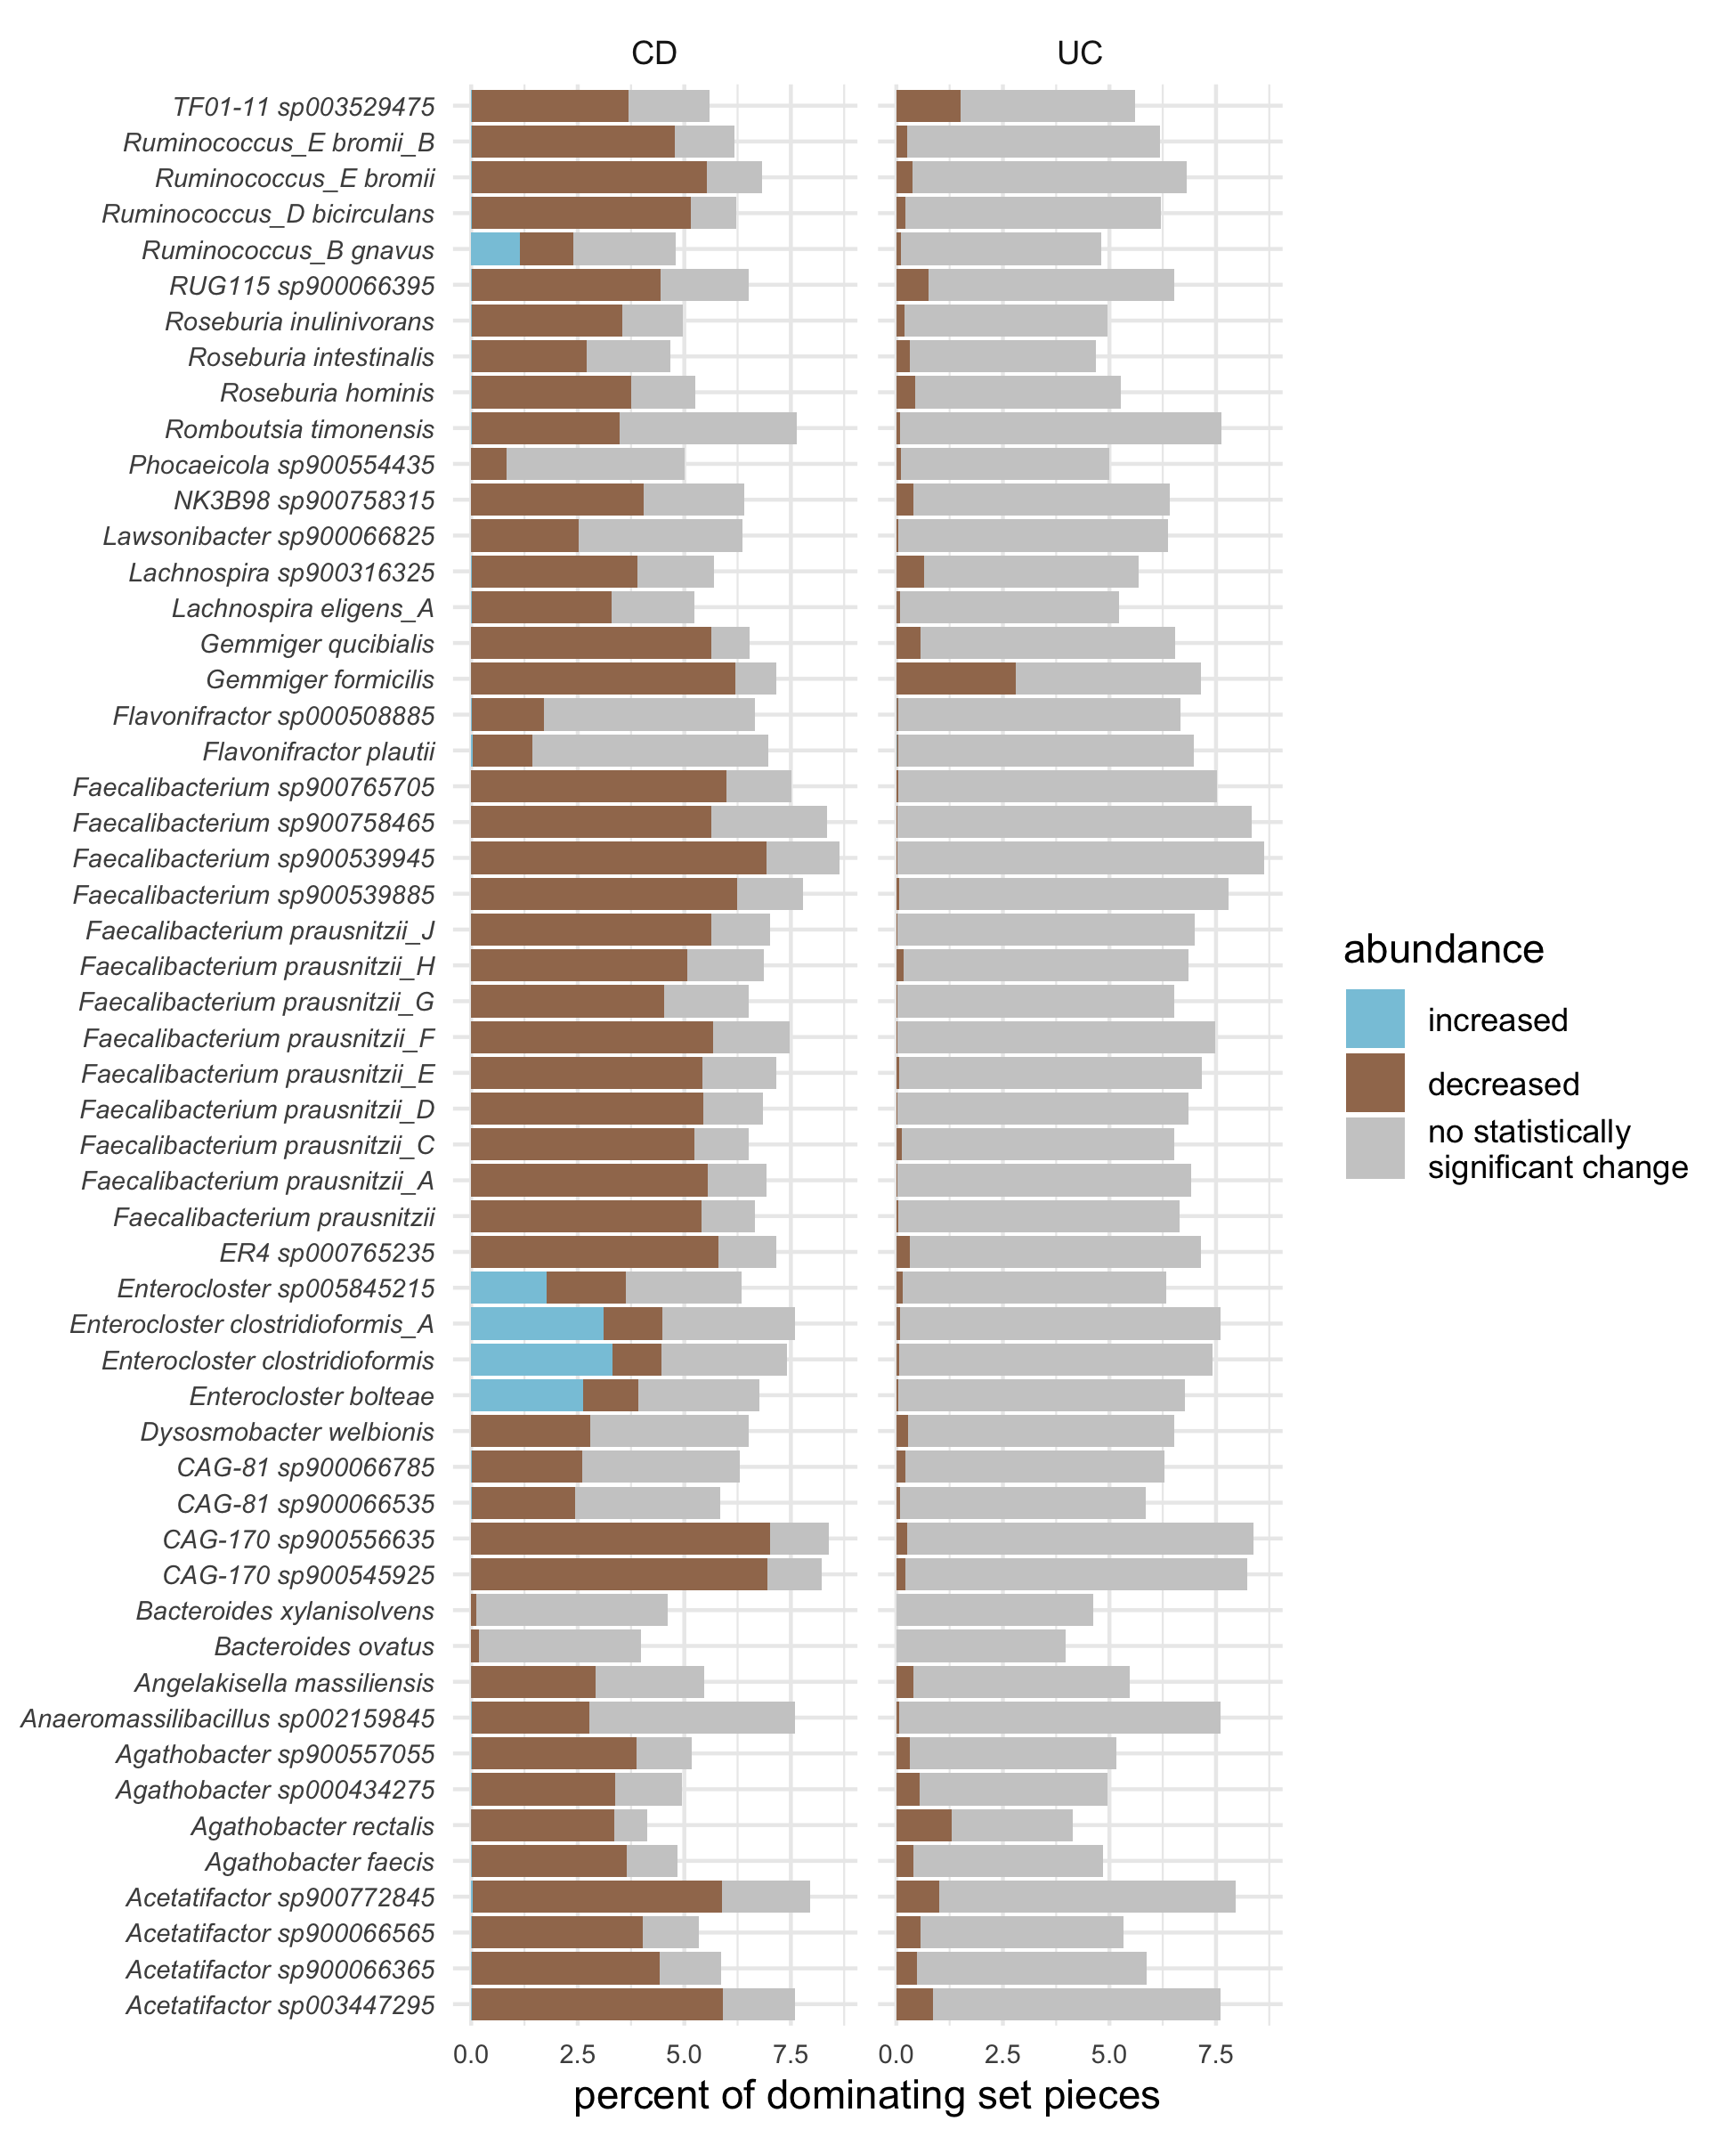

In [19]:
plt <- ggplot(corncob_summarized , aes(x = species, y = pct, fill = abundance)) +
  geom_col() +
  coord_flip() +
  theme_minimal() +
  theme(axis.text = element_text(size = 7),
        axis.title.y = element_blank(),
        axis.text.y = element_text(face ="italic")) +
  facet_wrap(~mu) +
  labs(x = "species", y = "percent of dominating set pieces") +
  scale_fill_manual(values = c("#CCCCCC", "#a1785c", "#88c7dc"),
                    guide = guide_legend(reverse = TRUE),
                    labels = c("no statistically\nsignificant change",  "decreased", "increased"))

plt

### Determine average percent of dominating set pieces tested

In [20]:
# what total percent of dom set pieces were tested?
corncob_summarized %>%
  filter(mu == "CD") %>%
  group_by(accession) %>%
  summarize(total_percent = sum(pct)) %>%
  ungroup() %>%
  summarize(mean_percent_tested = mean(total_percent))

mean_percent_tested
<dbl>
6.426137


### Plot as tree

In [21]:
destfile <- "inputs/gtdb_trees/bac120_r202.tree"
url <- "https://data.gtdb.ecogenomic.org/releases/release202/202.0/bac120_r202.tree"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}

In [24]:
gtdb_tree <- phytools::read.newick(destfile)
# drop tips from GTDB. This tree contains all GTDB species.
drop_tips <- gtdb_tree$tip.label[!str_detect(gtdb_tree$tip.label, paste(lineages$accession, collapse="|"))]
gtdb_tree <- ape::drop.tip(gtdb_tree, drop_tips)
# edit tip labels to remove GC/RS
gtdb_tree$tip.label <- gsub("RS_", "", gtdb_tree$tip.label) 
gtdb_tree$tip.label <- gsub("GB_", "", gtdb_tree$tip.label) 

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by coercion”
Warning message in getEdgeLength(text, i):
“NAs introduced by co

In [25]:
# order lineages by tip labels
corncob_summarized  <- corncob_summarized[match(gtdb_tree$tip.label, corncob_summarized$accession), ]

In [26]:
p_bac <- ggtree(gtdb_tree) %<+% corncob_summarized
  #geom_tiplab(size = 2) + 
  #coord_cartesian(clip = 'off') +
  #theme_tree2(plot.margin=margin(6, 120, 6, 6))

In [27]:
# edit tip labels to species names
p_bac$data$label <- ifelse(p_bac$data$label %in% corncob_summarized$accession, corncob_summarized$species, p_bac$data$label)

In [28]:
p_bac <- p_bac +
  geom_tippoint(aes(color = family), size = 1.5) +
  scale_color_brewer(palette = "Dark2") +
  theme(legend.text = element_text(face = "italic"))

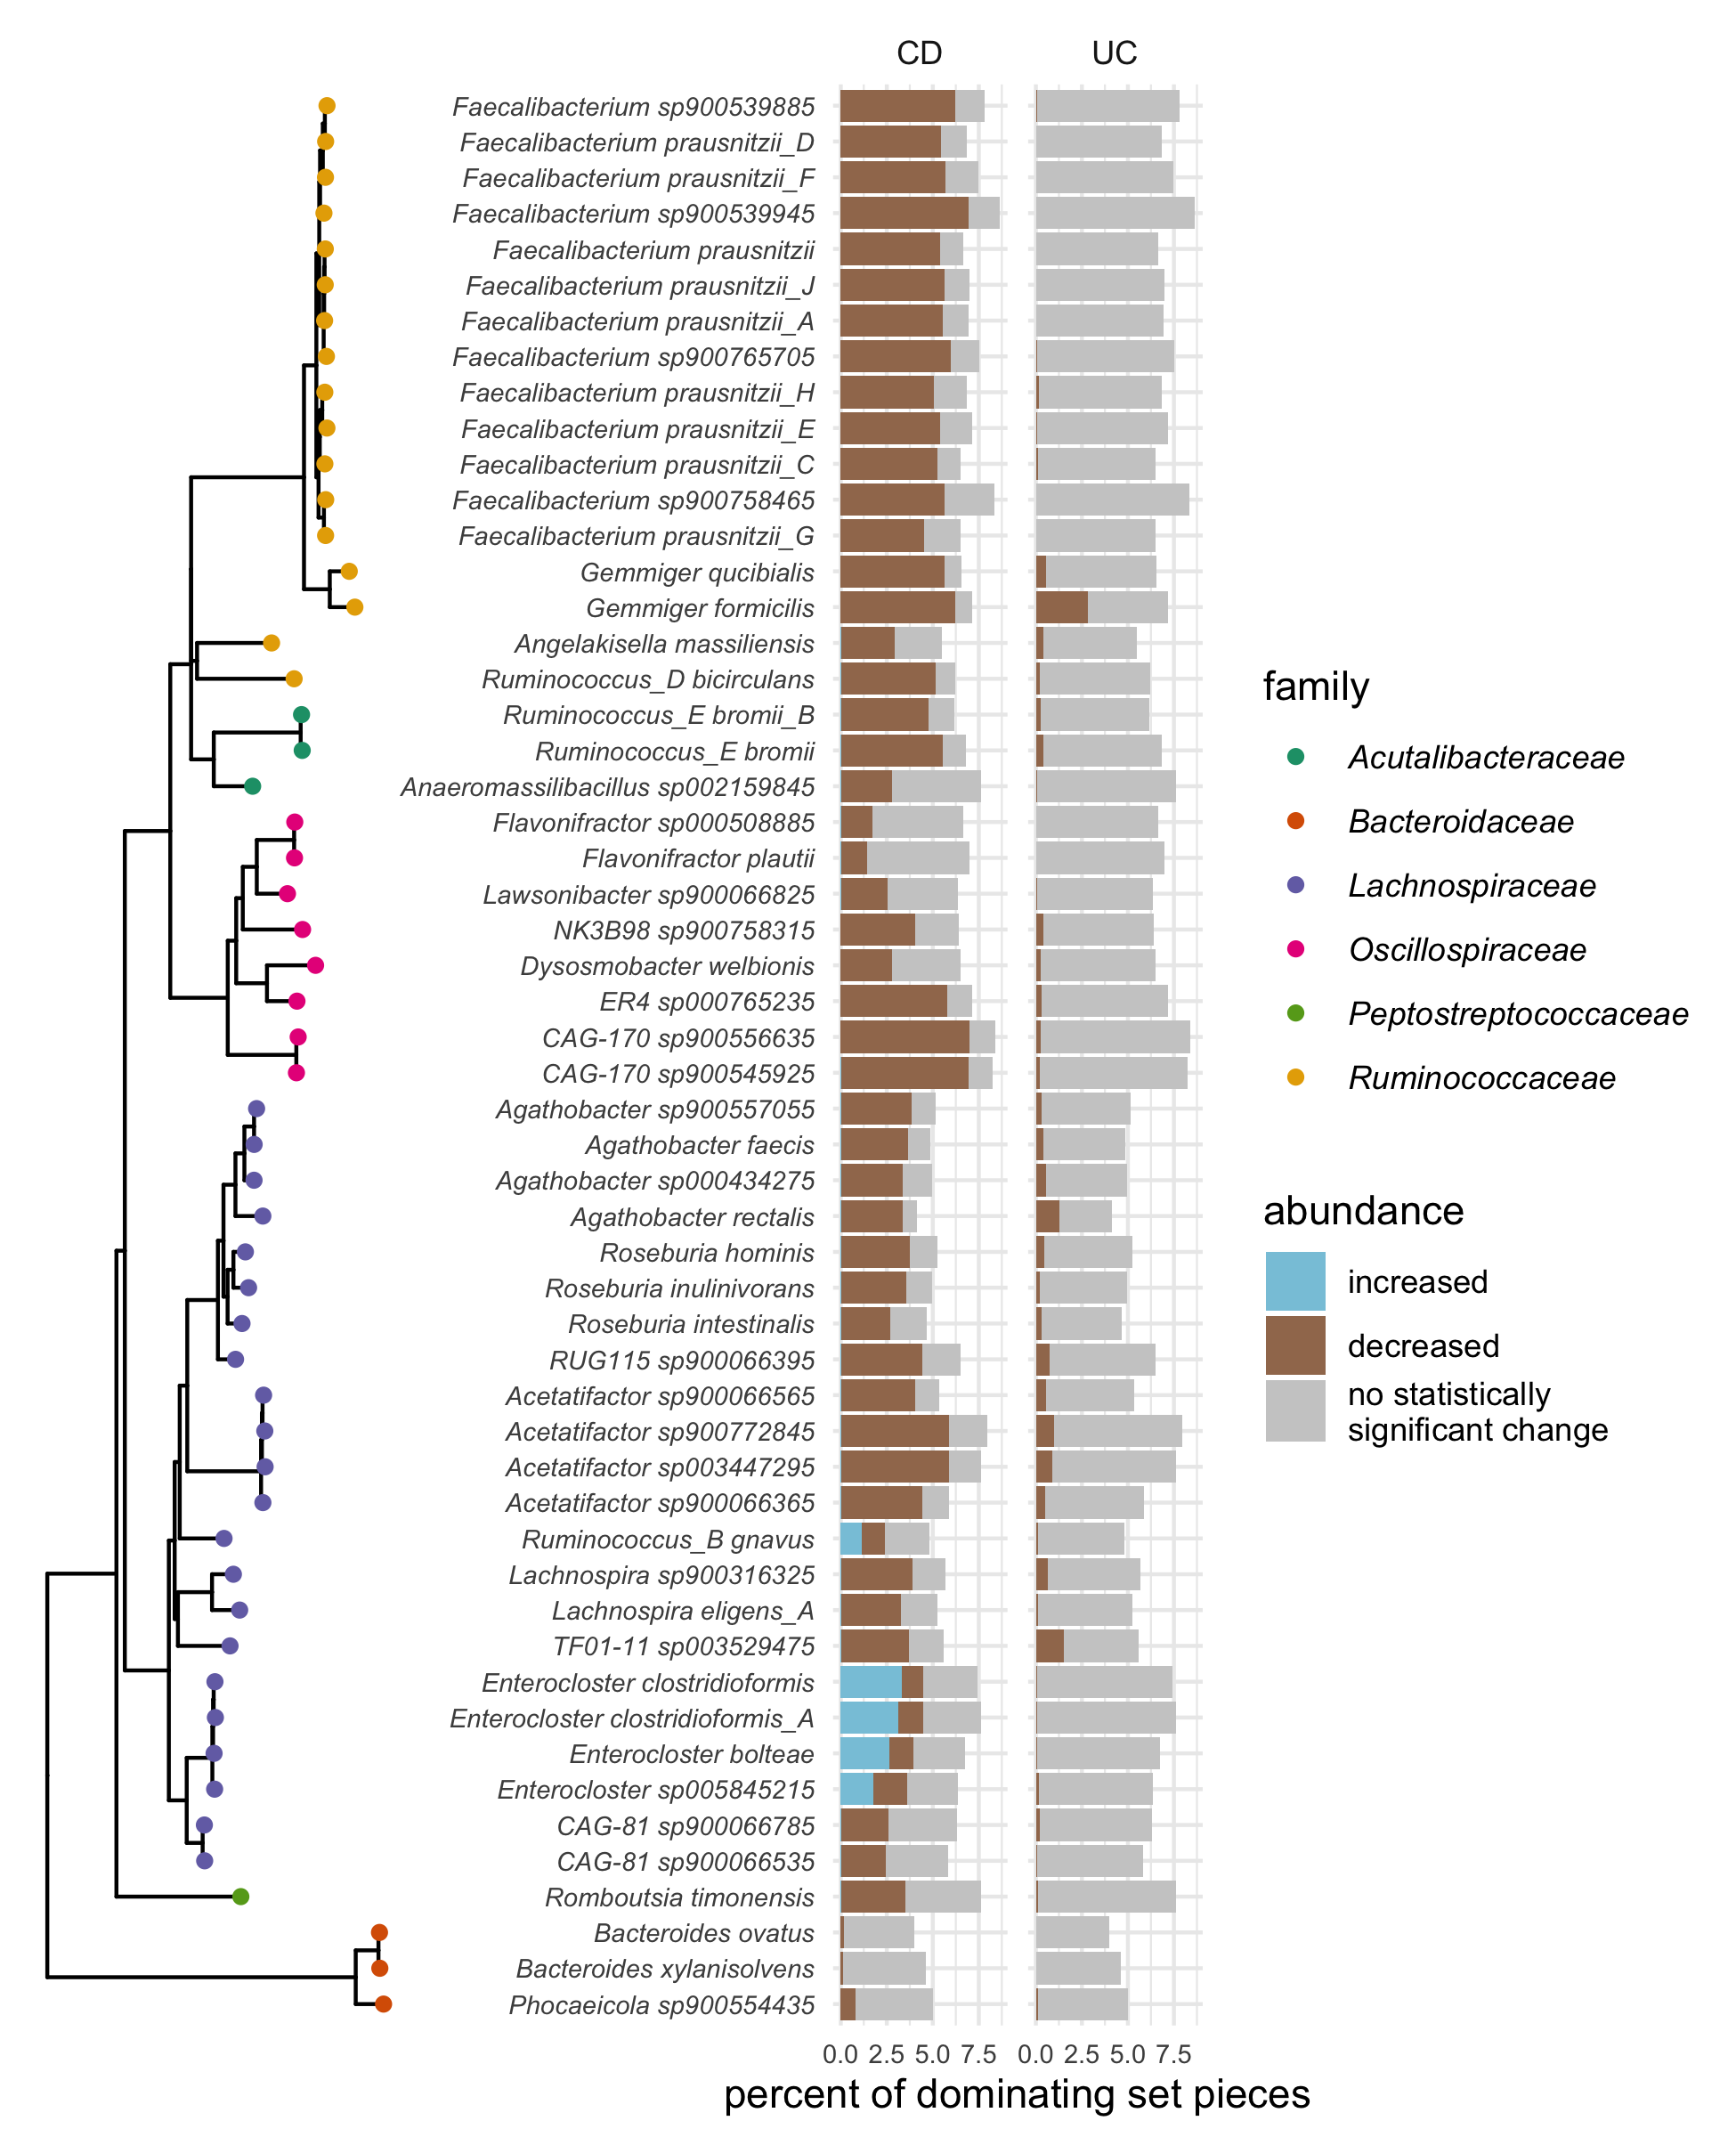

In [29]:
#pdf("figures/gtdb_and_corncob_res.pdf", width = 6.5, height = 7)
plt %>% insert_left(p_bac)
#dev.off()